In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import glob

def load_training_data(data_dir, num_samples=150):
    """
    Load MRI slices and masks from .h5 files
    Returns: images array, masks array
    """
    image_list = []
    mask_list = []
    
    # Get all .h5 files
    files = glob.glob(f'{data_dir}/*.h5')[:num_samples]
    
    for file_path in files:
        with h5py.File(file_path, 'r') as f:
            image = f['image'][:]
            mask = f['mask'][:]
            
            # Only keep slices with tumor
            if np.sum(mask > 0) > 100:
                # Normalize per-slice
                image = (image - image.min()) / (image.max() - image.min() + 1e-8)
                
                image_list.append(image)
                mask_list.append(mask)
    
    images = np.array(image_list)
    masks = np.array(mask_list)
    
    # Convert masks to binary
    masks = (masks > 0).astype(np.float32)
    
    return images, masks

# Load data
data_dir = './data/BraTS/BraTS2020_training_data/content/data'
X, y = load_training_data(data_dir, num_samples=300)

print(f"Loaded {len(X)} slices")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Loaded 118 slices
Image shape: (118, 240, 240, 4)
Mask shape: (118, 240, 240, 3)


In [3]:
# 1. Set seeds at the very top
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 2. Train/Val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training: {len(X_train)} slices")
print(f"Validation: {len(X_val)} slices")

# 3. Calculate class weights
tumor_pixels = np.sum(y_train)
background_pixels = y_train.size - tumor_pixels
weight_for_tumor = background_pixels / tumor_pixels
print(f"Tumor weight: {weight_for_tumor:.2f}")

# 4. Build model
def build_unet(input_shape=(240, 240, 4)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create augmentation generator
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

model = build_unet()

# 5. Define metrics and loss
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# 6. Compile with dice loss and lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=dice_loss,
    metrics=[dice_coef]
)

# 7. Create sample weights
sample_weights = np.ones(y_train.shape)  # (samples, height, width)
sample_weights[y_train[..., 0] == 1] = weight_for_tumor  # Weight tumor pixels

# 8. Train with sample weights
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=15, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    sample_weight=sample_weights,
    epochs=100,
    batch_size=4,
    callbacks=callbacks,
    verbose=1
)

Training: 94 slices
Validation: 24 slices
Tumor weight: 116.61
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - dice_coef: 0.0164 - loss: 1.4386

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - dice_coef: 0.0173 - loss: 1.4984 - val_dice_coef: 0.0221 - val_loss: 0.9779
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - dice_coef: 0.0200 - loss: 1.4328

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - dice_coef: 0.0231 - loss: 1.4891 - val_dice_coef: 0.0316 - val_loss: 0.9684
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - dice_coef: 0.0261 - loss: 1.4236

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - dice_coef: 0.0274 - loss: 1.4823 - val_dice_coef: 0.0344 - val_loss: 0.9656
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.0304 - loss: 1.4176

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - dice_coef: 0.0378 - loss: 1.4668 - val_dice_coef: 0.0910 - val_loss: 0.9090
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.1936 - loss: 1.1634

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - dice_coef: 0.2953 - loss: 1.0696 - val_dice_coef: 0.3807 - val_loss: 0.6193
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - dice_coef: 0.3850 - loss: 0.8907

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 483ms/step - dice_coef: 0.4170 - loss: 0.8895 - val_dice_coef: 0.4274 - val_loss: 0.5726
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - dice_coef: 0.4346 - loss: 0.8681 - val_dice_coef: 0.4118 - val_loss: 0.5882
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - dice_coef: 0.3976 - loss: 0.9204 - val_dice_coef: 0.4252 - val_loss: 0.5748
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - dice_coef: 0.4563 - loss: 0.8370 - val_dice_coef: 0.4188 - val_loss: 0.5812
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - dice_coef: 0.4397 - loss: 0.8173

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 483ms/step - dice_coef: 0.4507 - loss: 0.8441 - val_dice_coef: 0.4288 - val_loss: 0.5712
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - dice_coef: 0.4484 - loss: 0.8050

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - dice_coef: 0.4608 - loss: 0.8289 - val_dice_coef: 0.4299 - val_loss: 0.5701
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - dice_coef: 0.4538 - loss: 0.7987

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - dice_coef: 0.4657 - loss: 0.8235 - val_dice_coef: 0.4300 - val_loss: 0.5700
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - dice_coef: 0.4503 - loss: 0.8030

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - dice_coef: 0.4629 - loss: 0.8273 - val_dice_coef: 0.4326 - val_loss: 0.5674
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - dice_coef: 0.4502 - loss: 0.8033

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - dice_coef: 0.4634 - loss: 0.8262 - val_dice_coef: 0.4338 - val_loss: 0.5662
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - dice_coef: 0.4560 - loss: 0.7952

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - dice_coef: 0.4697 - loss: 0.8172 - val_dice_coef: 0.4349 - val_loss: 0.5651
Epoch 16/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - dice_coef: 0.4524 - loss: 0.7998

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - dice_coef: 0.4683 - loss: 0.8182 - val_dice_coef: 0.4357 - val_loss: 0.5643
Epoch 17/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - dice_coef: 0.4654 - loss: 0.7836

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - dice_coef: 0.4766 - loss: 0.8083 - val_dice_coef: 0.4358 - val_loss: 0.5642
Epoch 18/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.4599 - loss: 0.7901

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 470ms/step - dice_coef: 0.4737 - loss: 0.8112 - val_dice_coef: 0.4403 - val_loss: 0.5597
Epoch 19/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - dice_coef: 0.4676 - loss: 0.7805

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - dice_coef: 0.4779 - loss: 0.8060 - val_dice_coef: 0.4403 - val_loss: 0.5597
Epoch 20/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - dice_coef: 0.4673 - loss: 0.7806

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 464ms/step - dice_coef: 0.4781 - loss: 0.8053 - val_dice_coef: 0.4423 - val_loss: 0.5577
Epoch 21/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - dice_coef: 0.4806 - loss: 0.8022 - val_dice_coef: 0.4421 - val_loss: 0.5579
Epoch 22/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - dice_coef: 0.4742 - loss: 0.7716

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - dice_coef: 0.4815 - loss: 0.8013 - val_dice_coef: 0.4432 - val_loss: 0.5568
Epoch 23/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - dice_coef: 0.4759 - loss: 0.7693

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - dice_coef: 0.4829 - loss: 0.7987 - val_dice_coef: 0.4459 - val_loss: 0.5541
Epoch 24/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - dice_coef: 0.4815 - loss: 0.7622

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - dice_coef: 0.4869 - loss: 0.7943 - val_dice_coef: 0.4462 - val_loss: 0.5538
Epoch 25/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - dice_coef: 0.4875 - loss: 0.7916 - val_dice_coef: 0.4460 - val_loss: 0.5540
Epoch 26/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - dice_coef: 0.4886 - loss: 0.7546

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - dice_coef: 0.4932 - loss: 0.7878 - val_dice_coef: 0.4549 - val_loss: 0.5451
Epoch 27/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - dice_coef: 0.4900 - loss: 0.7872 - val_dice_coef: 0.4517 - val_loss: 0.5483
Epoch 28/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - dice_coef: 0.4964 - loss: 0.7495

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - dice_coef: 0.4990 - loss: 0.7845 - val_dice_coef: 0.4616 - val_loss: 0.5384
Epoch 29/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - dice_coef: 0.4922 - loss: 0.7477

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - dice_coef: 0.4964 - loss: 0.7823 - val_dice_coef: 0.4712 - val_loss: 0.5288
Epoch 30/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - dice_coef: 0.4278 - loss: 0.8728 - val_dice_coef: 0.4539 - val_loss: 0.5461
Epoch 31/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - dice_coef: 0.4419 - loss: 0.8505 - val_dice_coef: 0.4516 - val_loss: 0.5484
Epoch 32/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - dice_coef: 0.4552 - loss: 0.8318 - val_dice_coef: 0.4577 - val_loss: 0.5423
Epoch 33/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - dice_coef: 0.4647 - loss: 0.8192 - val_dice_coef: 0.4484 - val_loss: 0.5516
Epoch 34/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - dice_coef: 0.4691 - loss: 0.8148 - val_dice_coef: 0.4612 - val_loss: 0.5388
Epoch 35/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - dice_coef: 0.4805 - loss: 0.7978 - val_dice_coef: 0.4478 - val_loss: 0.5522
Epoch 36/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - dice_coef: 0.4854 - loss:

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - dice_coef: 0.5032 - loss: 0.7679 - val_dice_coef: 0.4972 - val_loss: 0.5028
Epoch 44/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - dice_coef: 0.5325 - loss: 0.7273 - val_dice_coef: 0.4961 - val_loss: 0.5039
Epoch 45/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - dice_coef: 0.5463 - loss: 0.7145 - val_dice_coef: 0.4806 - val_loss: 0.5194
Epoch 46/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - dice_coef: 0.5551 - loss: 0.7013 - val_dice_coef: 0.4749 - val_loss: 0.5251
Epoch 47/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - dice_coef: 0.5610 - loss: 0.6569

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - dice_coef: 0.5551 - loss: 0.7022 - val_dice_coef: 0.5019 - val_loss: 0.4981
Epoch 48/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - dice_coef: 0.5690 - loss: 0.6790 - val_dice_coef: 0.4812 - val_loss: 0.5188
Epoch 49/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - dice_coef: 0.5666 - loss: 0.6828 - val_dice_coef: 0.4874 - val_loss: 0.5126
Epoch 50/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - dice_coef: 0.5720 - loss: 0.6738 - val_dice_coef: 0.4921 - val_loss: 0.5079
Epoch 51/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - dice_coef: 0.5708 - loss: 0.6764 - val_dice_coef: 0.4848 - val_loss: 0.5152
Epoch 52/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - dice_coef: 0.5748 - loss: 0.6367

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - dice_coef: 0.5736 - loss: 0.6750 - val_dice_coef: 0.5035 - val_loss: 0.4965
Epoch 53/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - dice_coef: 0.5864 - loss: 0.6195

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - dice_coef: 0.5865 - loss: 0.6541 - val_dice_coef: 0.5196 - val_loss: 0.4804
Epoch 54/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - dice_coef: 0.5694 - loss: 0.6673 - val_dice_coef: 0.5132 - val_loss: 0.4868
Epoch 55/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - dice_coef: 0.6027 - loss: 0.6222 - val_dice_coef: 0.5078 - val_loss: 0.4922
Epoch 56/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - dice_coef: 0.5196 - loss: 0.6941

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - dice_coef: 0.5280 - loss: 0.7203 - val_dice_coef: 0.5210 - val_loss: 0.4790
Epoch 57/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - dice_coef: 0.5431 - loss: 0.6698

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - dice_coef: 0.5493 - loss: 0.6937 - val_dice_coef: 0.5331 - val_loss: 0.4669
Epoch 58/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - dice_coef: 0.5719 - loss: 0.6345

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - dice_coef: 0.5762 - loss: 0.6598 - val_dice_coef: 0.5444 - val_loss: 0.4556
Epoch 59/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - dice_coef: 0.5939 - loss: 0.6288 - val_dice_coef: 0.4965 - val_loss: 0.5035
Epoch 60/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - dice_coef: 0.5945 - loss: 0.6373 - val_dice_coef: 0.4974 - val_loss: 0.5026
Epoch 61/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - dice_coef: 0.5999 - loss: 0.6303 - val_dice_coef: 0.5264 - val_loss: 0.4736
Epoch 62/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - dice_coef: 0.6169 - loss: 0.6067 - val_dice_coef: 0.5341 - val_loss: 0.4659
Epoch 63/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - dice_coef: 0.6190 - loss: 0.5965 - val_dice_coef: 0.5020 - val_loss: 0.4980
Epoch 64/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - dice_coef: 0.6240 - loss: 0.5883 - val_dice_coef: 0.4930 - val_loss: 0.5070
Epoch 65/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - dice_coef: 0.6135 - loss:

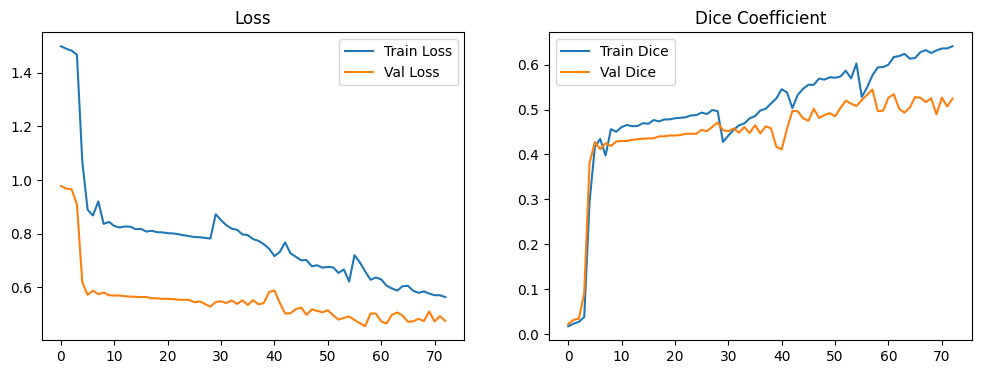

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


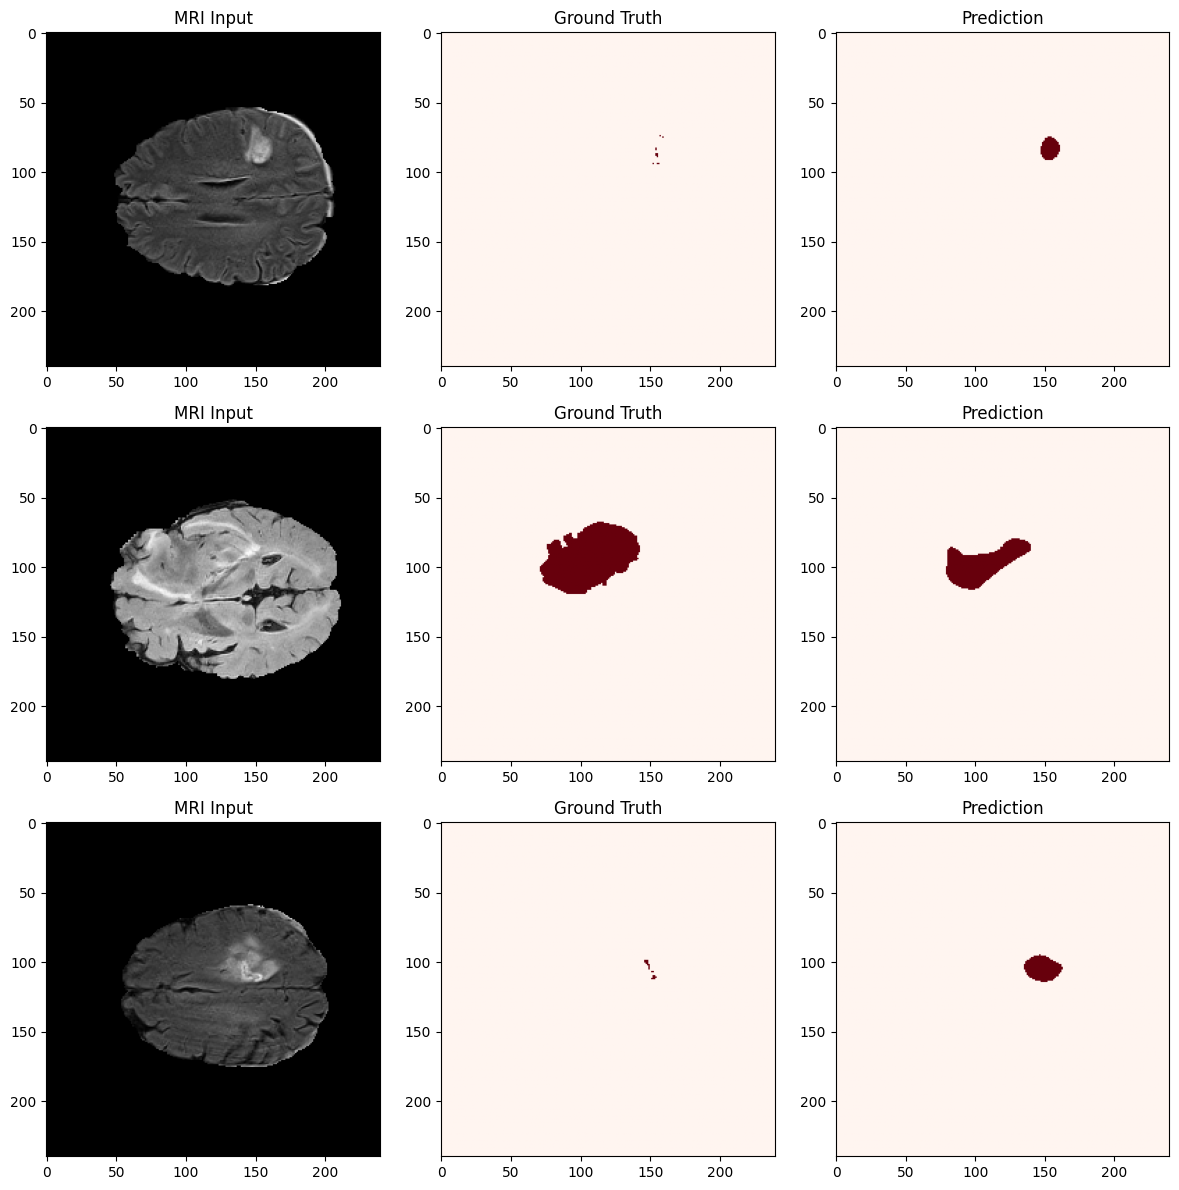

In [5]:
# Predict on validation set
predictions = model.predict(X_val)

# Visualize
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    axes[i, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title('MRI Input')
    
    axes[i, 1].imshow(y_val[i, :, :, 0], cmap='Reds')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i, :, :, 0] > 0.5, cmap='Reds')
    axes[i, 2].set_title('Prediction')

plt.tight_layout()
plt.show()